In [1]:
from helpers import *
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [64]:
articles, categories, links, paths_finished, paths_unfinished, paths_all, shortest_path_distance = load_data()

In [62]:
# get the data
articles, categories, links, paths_finished, paths_unfinished, paths_all, shortest_path_distance = load_data()

#remove the paths that has only a starting point and are not of our interest
paths_unfinished = paths_unfinished[paths_unfinished.pathLength > 1]

# Create the graphs of interest
G_paths, G_links = get_graphs(paths_all,links)
G_paths_finished, _ = get_graphs(paths_finished,links)
G_paths_unfinished, _ = get_graphs(paths_unfinished,links)

In [3]:
# Get the number of finished and unfinished node_visited 
nb_finished_node_visited = paths_finished.pathLength.sum()
nb_unfinished_node_visited = paths_unfinished.pathLength.sum()
nb_finished_node_visited, nb_unfinished_node_visited

(346767, 124081)

In [4]:
def get_in_out_degree(G, page) :
    in_deg = G.in_degree(page, 'weight')
    in_deg = in_deg if in_deg else 0
    out_deg = G.out_degree(page, 'weight')
    out_deg = out_deg if out_deg else 0
    
    return [in_deg, out_deg]
get_in_out_degree(G_paths, 'Áedán_mac_Gabráin') 

[0, 0]

## Construct the df for the categories with the variables of interest

In [5]:
def add_in_out_deg(cat, G):
    cat['in_deg'] = cat.article.apply(
        lambda art: get_in_out_degree(G, art)[0])
    cat['out_deg'] = cat.article.apply(
        lambda art: get_in_out_degree(G, art)[1])
    cat['mean_in_out_deg'] = (cat['in_deg']+cat['out_deg'])/2
    return cat

def split_cat(cat):
    cat['splitted_cat'] = cat.category.apply(lambda x : x.split('.')[1:])
    return cat

def get_sum_in_out_by_cat(cat):
    cat = cat.explode('splitted_cat')
    cat = cat.groupby('splitted_cat').apply(lambda x : pd.Series({
        'sum_in_deg' : x.in_deg.sum(),
        'sum_out_deg' : x.out_deg.sum(),
        'sum_mean_in_out_deg' : x.mean_in_out_deg.sum() 
    }))
    return cat

def get_cat_summary(cat, G):
    cat = add_in_out_deg(cat, G)
    cat = split_cat(cat)
    cat = get_sum_in_out_by_cat(cat)
    return cat
categories_finished = categories.copy()
categories_unfinished = categories.copy()

categories_finished= get_cat_summary(categories_finished, G_paths_finished)
categories_unfinished= get_cat_summary(categories_unfinished, G_paths_unfinished)

# Divide the sums by the number of node and multiply by 1000 so that it is easier to read
categories_finished = categories_finished/nb_finished_node_visited*1000
categories_unfinished = categories_unfinished/nb_unfinished_node_visited*1000

categories_finished = categories_finished.rename(columns = {'sum_in_deg'  : 'frac_in_deg_finished',
                                                  'sum_out_deg' : 'frac_out_deg_finished',
                                                  'sum_mean_in_out_deg' : 'frac_mean_in_out_deg_finished'})
categories_unfinished = categories_unfinished.rename(columns ={'sum_in_deg'  : 'frac_in_deg_unfinished',
                                                  'sum_out_deg' : 'frac_out_deg_unfinished',
                                                  'sum_mean_in_out_deg' : 'frac_mean_in_out_deg_unfinished'})

In [6]:
categories_finished

,frac_in_deg_finished,frac_out_deg_finished,frac_mean_in_out_deg_finished
splitted_cat,,,
Actors_models_and_celebrities,0.565221,0.997788,0.781505
African_Countries,11.154464,10.231654,10.693059
African_Geography,24.892795,24.243945,24.568370
Air_and_Sea_transport,2.015763,2.099392,2.057578
Ancient_History_Classical_History_and_Mythology,14.320855,14.283366,14.302111
...,...,...,...
Theatre,2.707870,5.516673,4.112271
USA_Presidents,5.017779,3.901755,4.459767
Websites_and_the_Internet,5.813702,5.943472,5.878587


In [7]:
#We join all the categories
categories_all = categories_finished.join(categories_unfinished)

In [8]:
categories_all['diff_in'] = categories_all.apply(lambda x: 
            (x.frac_in_deg_finished - x.frac_in_deg_unfinished) , axis = 1)
categories_all['diff_out'] = categories_all.apply(lambda x: 
            (x.frac_out_deg_finished - x.frac_out_deg_unfinished), axis = 1)
categories_all['diff_mean_in_out'] = categories_all.apply(lambda x: 
            (x.frac_mean_in_out_deg_finished - x.frac_mean_in_out_deg_unfinished), axis = 1)
categories_all['weighted_diff_in'] = categories_all.apply(lambda x: 
            (x.frac_in_deg_finished - x.frac_in_deg_unfinished) /(x.frac_in_deg_finished + x.frac_in_deg_unfinished), axis = 1)
categories_all['weighted_diff_out'] = categories_all.apply(lambda x: 
            (x.frac_out_deg_finished - x.frac_out_deg_unfinished) /(x.frac_out_deg_finished + x.frac_out_deg_unfinished), axis = 1)
categories_all['weighted_diff_mean_in_out'] = categories_all.apply(lambda x: 
            (x.frac_mean_in_out_deg_finished - x.frac_mean_in_out_deg_unfinished)/(x.frac_mean_in_out_deg_finished + x.frac_mean_in_out_deg_unfinished), axis = 1)
categories_all['frac_finished_for_degree'] = categories_all.apply(lambda x: 
            (x.frac_mean_in_out_deg_finished)/(x.frac_mean_in_out_deg_finished + x.frac_mean_in_out_deg_unfinished), axis = 1)

categories_all['diff_finished'] = categories_all.apply(lambda x: 
            (x.frac_in_deg_finished - x.frac_out_deg_finished) , axis = 1)
categories_all['diff_unfinished'] = categories_all.apply(lambda x: 
            (x.frac_in_deg_finished - x.frac_out_deg_unfinished), axis = 1)
categories_all['weighted_diff_finished'] = categories_all.apply(lambda x: 
            (x.frac_in_deg_finished - x.frac_out_deg_finished)/(x.frac_in_deg_finished + x.frac_out_deg_finished) , axis = 1)
categories_all['weighted_diff_unfinished'] = categories_all.apply(lambda x: 
            (x.frac_in_deg_finished - x.frac_out_deg_unfinished)/(x.frac_in_deg_finished + x.frac_out_deg_finished), axis = 1)

In [9]:
categories_all[['weighted_diff_mean_in_out', 'weighted_diff_finished', 'weighted_diff_unfinished']].head(5)

,weighted_diff_mean_in_out,weighted_diff_finished,weighted_diff_unfinished
splitted_cat,,,
Actors_models_and_celebrities,-0.089356,-0.276753,-0.370563
African_Countries,0.093909,0.043150,0.130787
African_Geography,0.118403,0.013205,0.123787
Air_and_Sea_transport,-0.036228,-0.020322,-0.111400
Ancient_History_Classical_History_and_Mythology,-0.011662,0.001311,0.008437


## Difference between of node in/out degree between finished and unfineshed graphs 

Now that we have all the features we needed we can start looking at results. 

First we plot the difference between finished and unfineshed graphs of node degree (that we set to $\frac{deg_{in}+deg_{out}}{2}$). The node degree can be seen as how many time we use the concept during a game. If the difference between finished and unfinished of a concept degree is high it means that the concept is more used in finished paths than in unfinished and that maybe players should go more to this concept page to improve the finished game rate. On the other hand, a big negative difference would mean that this concept should be avoided.

_Note_ : We have to be carefull with the results because maybe it is not the choice of the player to go to these concepts but he might have been forced by the starting or target page. We analyse this deeper in a later section. However, this would already tell us that concepts might be harder than others 

### Histogram of the absolute difference  between finished and unfineshed graphs of node degree

We can see that there are no concepts where people get more stuck in unfinished paths than in finished. However, we can see that finished paths have concepts where we can go that may be more useful and help the players find their way.

However, we have to be carefull because maybe the difference of 10 is between 610 and 600 which does not mean the same thing as the difference between 5 and 15. Therefore we divide the node degree by the sum of degrees.

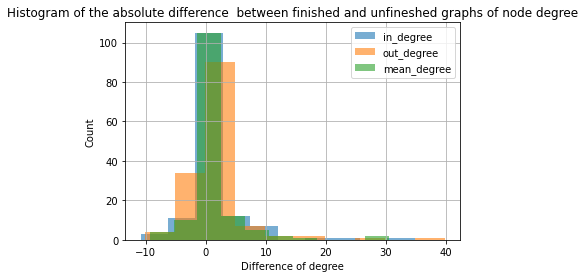

In [10]:
def get_first_last(n, df, cat):
    df_sorted_cat = df[cat].sort_values()
    return df_sorted_cat[-n :][::-1], df_sorted_cat[:n]

categories_all.diff_in.hist(alpha = 0.6, label = 'in_degree').set_title('Histogram of the absolute difference  between finished and unfineshed graphs of node degree')
categories_all.diff_out.hist(alpha = 0.6, label = 'out_degree')
categories_all.diff_mean_in_out.hist(alpha = 0.6, label = 'mean_degree')
plt.xlabel('Difference of degree')
plt.ylabel('Count')
plt.legend()

### Histogram of the weighted difference between of node in/out degree between finished and unfineshed graphs

From this we can see that there are some concepts that are more used in the unfinished paths that are all related to art/movies/theatre. On the other hand, some concepts like History/chemistry are more used in finished paths.


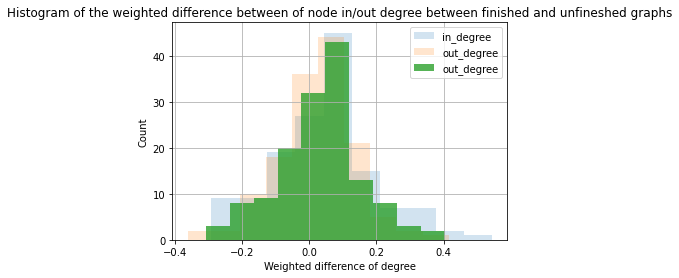

In [11]:
categories_all.weighted_diff_in.hist(alpha = 0.2, label = 'in_degree').set_title('Histogram of the weighted difference between of node in/out degree between finished and unfineshed graphs')
categories_all.weighted_diff_out.hist(alpha = 0.2, label = 'out_degree')
categories_all.weighted_diff_mean_in_out.hist(alpha = 0.8, label = 'out_degree')

plt.xlabel('Weighted difference of degree')
plt.ylabel('Count')
plt.legend()

In [12]:
get_first_last(8, categories_all, 'weighted_diff_mean_in_out')

(splitted_cat
 General_Chemistry            0.404116
 Chemical_elements            0.347463
 Chemistry                    0.315946
 Software                     0.276284
 Middle_Eastern_Countries     0.262108
 Dinosaurs                    0.261413
 Monarchs_of_Great_Britain    0.253200
 Musical_Instruments          0.242753
 Name: weighted_diff_mean_in_out, dtype: float64,
 splitted_cat
 Theatre                                 -0.308249
 Literature_types                        -0.265847
 Community_organisations                 -0.241093
 Architecture                            -0.236895
 Railway_transport                       -0.220437
 Producers_directors_and_media_figures   -0.206322
 Sports                                  -0.206229
 Films                                   -0.196905
 Name: weighted_diff_mean_in_out, dtype: float64)

### Histogram of the fraction of use of the concept in finished path over all the time it was used

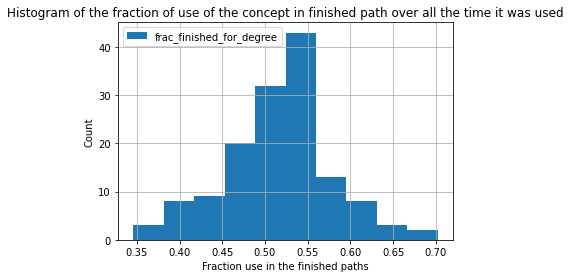

In [13]:
categories_all.frac_finished_for_degree.hist(label = 'frac_finished_for_degree').set_title('Histogram of the fraction of use of the concept in finished path over all the time it was used')
plt.xlabel('Fraction use in the finished paths')
plt.ylabel('Count')
plt.legend()

In [14]:
get_first_last(10, categories_all, 'frac_finished_for_degree')

(splitted_cat
 General_Chemistry                                          0.702058
 Chemical_elements                                          0.673732
 Chemistry                                                  0.657973
 Software                                                   0.638142
 Middle_Eastern_Countries                                   0.631054
 Dinosaurs                                                  0.630707
 Monarchs_of_Great_Britain                                  0.626600
 Musical_Instruments                                        0.621377
 British_History_1500_and_before_including_Roman_Britain    0.616516
 Antarctica                                                 0.609504
 Name: frac_finished_for_degree, dtype: float64,
 splitted_cat
 Theatre                                  0.345876
 Literature_types                         0.367076
 Community_organisations                  0.379453
 Architecture                             0.381552
 Railway_transport           

### Histogram of the weighted difference between of node in/out degree of big concepts between finished and unfineshed graphs
Finally we want to see only the difference in big concepts - concepts that often appear. For this we reduced the concepts we look at to only concepts that have at least 100 of in_degree.

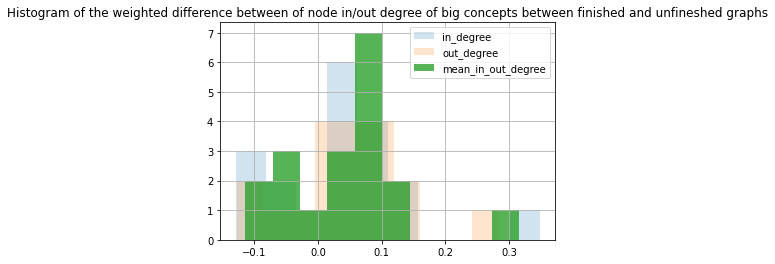

In [15]:
min_deg = 1000* 1/40 
categories_all[categories_all.frac_mean_in_out_deg_finished > min_deg].weighted_diff_in.hist(alpha = 0.2, label = 'in_degree').set_title('Histogram of the weighted difference between of node in/out degree of big concepts between finished and unfineshed graphs')
categories_all[categories_all.frac_mean_in_out_deg_finished > min_deg].weighted_diff_out.hist(alpha = 0.2, label = 'out_degree')
categories_all[categories_all.frac_mean_in_out_deg_finished > min_deg].weighted_diff_mean_in_out.hist(alpha = 0.8, label = 'mean_in_out_degree')
plt.legend()

In [16]:
categories_all[categories_all.frac_mean_in_out_deg_finished > min_deg][categories_all['weighted_diff_mean_in_out'] >0.05].weighted_diff_in.sort_values(ascending = False).index

C:\Users\mathi\AppData\Local\Temp/ipykernel_36136/3536877378.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  categories_all[categories_all.frac_mean_in_out_deg_finished > min_deg][categories_all['weighted_diff_mean_in_out'] >0.05].weighted_diff_in.sort_values(ascending = False).index


Index(['Chemistry', 'British_History', 'Physics', 'People', 'Science',
       'European_Geography', 'History', 'European_Countries',
       'General_Geography', 'Geography', 'Countries'],
      dtype='object', name='splitted_cat')

In [17]:
categories_all[categories_all.frac_mean_in_out_deg_finished > min_deg][categories_all['weighted_diff_mean_in_out'] < -0.015].weighted_diff_in.sort_values(ascending = False).index

C:\Users\mathi\AppData\Local\Temp/ipykernel_36136/4094025566.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  categories_all[categories_all.frac_mean_in_out_deg_finished > min_deg][categories_all['weighted_diff_mean_in_out'] < -0.015].weighted_diff_in.sort_values(ascending = False).index


Index(['Citizenship', 'Everyday_life', 'North_American_Geography',
       'Language_and_literature', 'General_Biology'],
      dtype='object', name='splitted_cat')

## Look at the difference between in and out degree in finished and unfinished paths 
diff = in_deg- out_deg. It implies that 
- if diff is big, it means that we came to this node but then came back to the previous one 
- if diff is small, it means that we get back and forth from this node not knowing how to escape

First, we see that nodes for finished paths are more balanced, which means the go back button was not used much in these concepts, whereas for unfinished paths it is skewed right but also to the left.

From this we see that we have both cases with unfinished paths and what is interesting is that the 
- the node they go to and then come back are the node used more in finished paths like politics/history/chemistry, which means that maybe they don't adopt the good strategy and should have continued in this direction.
- The node they cannot escape are the ones related to litterature which are the node used less in finished than in unfinished. So we might conclude that the players should escapte these node as soon as possible.

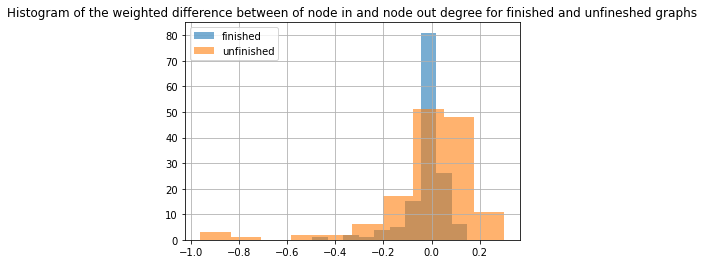

In [18]:
categories_all.weighted_diff_finished.hist(alpha = 0.6, label = 'finished').set_title('Histogram of the weighted difference between of node in and node out degree for finished and unfineshed graphs')
categories_all.weighted_diff_unfinished.hist(alpha = 0.6, label = 'unfinished')
plt.legend()

In [19]:
get_first_last(10, categories_all, 'weighted_diff_unfinished')

(splitted_cat
 General_Chemistry                                          0.302968
 Chemical_elements                                          0.268312
 British_History_1500_and_before_including_Roman_Britain    0.259631
 Chemistry                                                  0.243379
 Software                                                   0.237548
 Middle_Eastern_Countries                                   0.230772
 Musical_Instruments                                        0.226893
 Monarchs_of_Great_Britain                                  0.215164
 Geography_of_the_Middle_East                               0.202387
 World_War_II                                               0.200879
 Name: weighted_diff_unfinished, dtype: float64,
 splitted_cat
 Theatre                                 -0.961289
 Architecture                            -0.901713
 Literature_types                        -0.855537
 Cartoons                                -0.728956
 Producers_directors_and_medi

## Use Bokeh to plot results 

In [20]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool, ColorBar, ColorMapper,Range1d
output_notebook()
def get_color(x):
    if x.weighted_diff_mean_in_out < -0.3 or x.weighted_diff_unfinished < -0.3 :
        return 'red'
    elif x.weighted_diff_mean_in_out > 0.3 or x.weighted_diff_unfinished > 0.3 :
        return 'green'
    else :
        return 'blue'

Loading BokehJS ...

In [21]:
data = categories_all[['weighted_diff_unfinished', 'weighted_diff_mean_in_out']].reset_index()
data['color'] = data.apply(lambda x : get_color(x), axis = 1)
hover = HoverTool(
    tooltips=[
        ("Name", "@splitted_cat"),
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=760, plot_height=360, tools=tools, title="Comparing nodes used in un-finished paths and their percentage difference of in and out degree")
p.title.text_color = "black"
p.title.text_font_size = "15px"
p.xaxis.axis_label = 'Percentage difference of number of time node used in finished and unfinished paths'
p.yaxis.axis_label = 'Percentage difference of in and out degree for unfinished paths'

p.x_range = Range1d(-1,1)
p.y_range = Range1d(-1,1)

p.circle('weighted_diff_mean_in_out', 'weighted_diff_unfinished', color = 'color', source=data, size=15, alpha=0.5)

show(p, notebook_handle=True)

## Comparing subject of starting and end points 

In [22]:
categories['categories'] = categories.category.apply(lambda x : x.split('.')[1:])
categories_merged = pd.DataFrame(categories.groupby('article').categories.agg(sum))
#categories_merged = categories_merged.reset_index()

In [24]:
def get_categories(article, df):
    if article not in df.index :
        return [] 
    else : 
        return df.loc[article].categories

def get_start_target_cats(paths):
    paths['start'] = paths.path.apply(lambda x:x.split(';')[0])
    paths['start_cats'] = paths['start'].apply(lambda article : get_categories(article, categories_merged))
    paths['target_cats'] = paths['target'].apply(lambda article : get_categories(article, categories_merged))
    paths_start = paths.explode('start_cats').groupby('start_cats').start.agg(len)
    paths_target = paths.explode('target_cats').groupby('target_cats').target.agg(len)
    paths_out = pd.merge(paths_start, paths_target, right_index=True, left_index=True)
    return paths_out
    
start_target_cats_unfinished = get_start_target_cats(paths_unfinished[['path', 'target']].copy())
start_target_cats_finished = get_start_target_cats(paths_finished[['path', 'target']].copy())

In [25]:
start_target_cats_finished = start_target_cats_finished/nb_finished_node_visited*1000
start_target_cats_unfinished = start_target_cats_unfinished/nb_unfinished_node_visited*1000

start_target_cats_finished = start_target_cats_finished.add_suffix('_finished')
start_target_cats_unfinished = start_target_cats_unfinished.add_suffix('_unfinished')

In [26]:
start_target_cats = start_target_cats_finished.join(start_target_cats_unfinished)

In [27]:
start_target_cats['weighted_diff_start'] = start_target_cats.apply(lambda x: 
            (x.start_finished - x.start_unfinished) /(x.start_finished + x.start_unfinished), axis = 1)
start_target_cats['weighted_diff_target'] = start_target_cats.apply(lambda x: 
            (x.target_finished - x.target_unfinished) /(x.target_finished + x.target_unfinished), axis = 1)
start_target_cats['frac_start'] = start_target_cats.apply(lambda x: 
            (x.start_finished) /(x.start_finished + x.start_unfinished), axis = 1)
start_target_cats['frac_target'] = start_target_cats.apply(lambda x: 
            (x.target_finished) /(x.target_finished + x.target_unfinished), axis = 1)

### Plot the results
We plot two histograms 
- the histogram of the sucess rate of a concept as **starting page**.  
- the histogram of the sucess rate of a concept as **target page**.  

#### Starting page 
First we see that the starting page histogram has a smaller variance then the target page histogram. It is not a surprise since we know that the starting phase of going to a hub is the easiest part. Moreover we cannot say that a starting page is easier but there are still some pages that seems harder to start with `['Architecture', 'Theatre', 'Literature_types', 'General_Biology', 'Language_and_literature', 'Design_and_Technology', 'Air_and_Sea_transport', 'Conflict_and_Peace']`. In particular, starting with the topic `Architecture` lead to a probability of sucess of $0.26$ which means that the game is finished once over 4 attempts.

#### Target page 
In the target page histogram, we can see a lot of variance and there are topics that seems to be easier or harder than others. We can see that topics with _Geography_ or _countries_ are quiet easy. Topics as `European_Countries, USA_Presidents, European_Geography` are finished more than 4 times over 5 attemps.

On the other side, topics more related to _movies_ or to _litterature_ are harder. For example, the topic `'General_Literature'` has a score of $0.08$ which mean that a game is finished less than 1 times over 10 with this concept as target.

#### Conclusion
Some starting and target concepts has a big impact on the result of a game. We will use these two score for our regression.

(start_cats
 Engineers_and_inventors                     0.614189
 The_Planets                                 0.610307
 Natural_Disasters                           0.588696
 Human_Scientists                            0.577024
 Cryptography                                0.572984
 Computer_and_Video_games                    0.566904
 Middle_Eastern_Countries                    0.562389
 Philosophers                                0.560390
 Historians_chroniclers_and_history_books    0.556025
 Antarctica                                  0.554339
 Name: frac_start, dtype: float64,
 start_cats
 Architecture               0.269728
 Theatre                    0.332606
 Literature_types           0.339720
 Design_and_Technology      0.369822
 General_Biology            0.370208
 Language_and_literature    0.375752
 Air_and_Sea_transport      0.406406
 Conflict_and_Peace         0.414149
 Animal_and_Human_Rights    0.423541
 Storms                     0.438569
 Name: frac_start, dtype: float

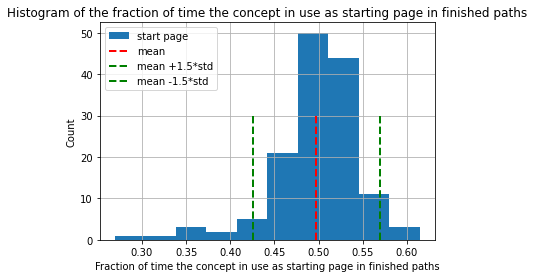

In [28]:
start_target_cats['frac_start'].hist(label = 'start page')\
            .set_title("""Histogram of the fraction of time the concept in use as starting page in finished paths""")
plt.xlabel('Fraction of time the concept in use as starting page in finished paths')
plt.ylabel('Count')
mean_frac_start, std_frac_start = start_target_cats['frac_start'].mean(), start_target_cats['frac_start'].std()

val_frac_start = 1.5
y_limit = 30
plt.vlines(mean_frac_start, 0, y_limit, ls='--', color='red', linewidth=2, label = 'mean')
plt.vlines(mean_frac_start+ val_frac_start *std_frac_start,  0, y_limit, ls='--', color='green', linewidth=2,label ='mean +'+str(val_frac_start)+'*std')
plt.vlines(mean_frac_start- val_frac_start * std_frac_start,  0, y_limit, ls='--', color='green', linewidth=2, label ='mean -'+str(val_frac_start)+'*std')

plt.legend()

get_first_last(10, start_target_cats, 'frac_start')

(start_cats
 European_Countries              0.850395
 USA_Presidents                  0.828968
 European_Geography              0.804207
 Asian_Countries                 0.795314
 Middle_Eastern_Countries        0.786535
 African_Countries               0.786076
 Countries                       0.785872
 Languages                       0.779158
 African_Geography               0.768114
 Geography_of_the_Middle_East    0.766678
 Name: frac_target, dtype: float64,
 start_cats
 General_Literature                       0.088525
 Cartoons                                 0.157733
 Actors_models_and_celebrities            0.158481
 Games                                    0.186206
 Conflict_and_Peace                       0.189713
 Novels                                   0.203694
 Sports_and_games_people                  0.245845
 Television                               0.248437
 Community_organisations                  0.251930
 Producers_directors_and_media_figures    0.254799
 Name: fra

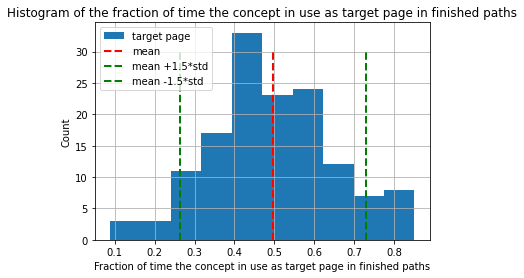

In [29]:
# Look at the target page now
start_target_cats['frac_target'].hist(label = 'target page')\
            .set_title("""Histogram of the fraction of time the concept in use as target page in finished paths""")
plt.xlabel('Fraction of time the concept in use as target page in finished paths')
plt.ylabel('Count')
mean_frac_target, std_frac_target = start_target_cats['frac_target'].mean(), start_target_cats['frac_target'].std()

val_frac_target = 1.5
y_limit = 30
plt.vlines(mean_frac_target, 0, y_limit, ls='--', color='red', linewidth=2, label = 'mean')
plt.vlines(mean_frac_target+ val_frac_target *std_frac_target,  0, y_limit, ls='--', color='green', linewidth=2,label ='mean +'+str(val_frac_target)+'*std')
plt.vlines(mean_frac_target- val_frac_target * std_frac_target,  0, y_limit, ls='--', color='green', linewidth=2, label ='mean -'+str(val_frac_target)+'*std')

plt.legend()
plt.legend()
# Get the easiest and hardest finishing pages
get_first_last(10, start_target_cats, 'frac_target')

## Plots

We plot the impact on the starting and the target paths on the fact of finishing the game 

In red are concepts that have bad impact on finishing a game and in green good impact. This is determined if the score of the starting or target concept is out of 1.5 of its mean 

In [30]:
def get_color_2(x):
    if x.frac_target < mean_frac_target-val_frac_target*std_frac_target \
            or x.frac_start < mean_frac_start-val_frac_start*std_frac_start :
        return 'red'
    elif x.frac_target > mean_frac_target+val_frac_target*std_frac_target \
            or x.frac_start > mean_frac_start+val_frac_start*std_frac_start :
        return 'green'
    else :
        return 'blue'
data = start_target_cats[['frac_start', 'frac_target']].reset_index()
data['color'] = data.apply(lambda x : get_color_2(x), axis = 1)
hover = HoverTool(
    tooltips=[
        ("Name", "@start_cats"),
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=660, plot_height=460, tools=tools, title="Comparing sucess of game with start and target topics")
p.title.text_color = "black"
p.title.text_font_size = "15px"
p.xaxis.axis_label = 'Sucess rate with this concept as starting edges'
p.yaxis.axis_label = 'Sucess rate with this concept as target edges'
p.x_range = Range1d(0,1)
p.y_range = Range1d(0,1)

p.circle('frac_start', 'frac_target', color = 'color', source=data, size=15, alpha=0.5)

show(p, notebook_handle=True)

## Add features 

In [53]:
def get_score(article, attribute):
    if article not in categories_merged_2.index :
        return 0.5
    arr = [start_target_cats.loc[cat][attribute] for cat in categories_merged_2.loc[article].categories ]
    return sum(arr)/len(arr)

In [ ]:
categories['categories'] = categories.category.apply(lambda x : [x.split('.')[-1]])
categories_merged_2 = pd.DataFrame(categories.groupby('article').categories.agg(sum))
features = paths_all[['path','target']].copy()
features['starting'] = features.path.apply(lambda x : x.split(';')[0])
features['target'] = features['target'].apply(lambda t : get_score(t, 'frac_target'))
features['starting'] = features['starting'].apply(lambda t : get_score(t, 'frac_start'))
features = features[['starting', 'target']]

In [ ]:
features

In [65]:
paths_all

,hashedIpAddress,timestamp,durationInSec,path,pathLength,target,type
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,9,African_slave_trade,finished
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,5,African_slave_trade,finished
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,8,African_slave_trade,finished
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,4,Greece,finished
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,7,John_F._Kennedy,finished
...,...,...,...,...,...,...,...
76188,109ed71f571d86e9,1389787605,180,Franz_Kafka;Tuberculosis;World_Health_Organiza...,8,Cholera,restart
76189,232f992e57d43e8d,1389787697,6,Modern_history,1,Hollandic,restart
76190,2e09a7224600a7cd,1389798400,1900,Computer_programming;Linguistics;Culture;Popul...,5,The_Beatles,timeout
76191,60af9e2138051b96,1389799481,1903,Jamaica;United_Kingdom;World_War_II;Battle_of_...,4,Alan_Turing,timeout
